In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
df=pd.read_csv('/home/ajitesh/ML/PasswordStrength/data.csv',error_bad_lines=False,warn_bad_lines=False)

# print("shape of the data is ",df.shape)
# print("="*50)
# print(df.info())
#observation , find that one password is missing in data.


In [ ]:
df.loc[pd.isnull(df["password"])==True]

In [ ]:
df.dropna(axis=0,inplace=True)

In [ ]:
sns.countplot(x='strength',data=df)
plt.show()
#observation , it is multiclass problem and dataset contain strong password, highly imbalance data

In [ ]:
df['password']=df['password'].astype(str)
df['length']=df['password'].astype(str).apply(lambda x:len(x))
#strength wise average length

sns.barplot(x ='strength', y ='length', data = df,palette ='plasma', estimator = np.mean)
plt.show()

In [ ]:
# strength wise std dev length
sns.barplot(x ='strength', y ='length', data = df,palette ='plasma',estimator = np.std)
plt.show()

In [ ]:
sns.catplot(x="strength", y="length", data=df)

In [ ]:
#from above figure I am sure that length>60 of strength=2 will be outlier
df.drop(df[df['length']>60].index,inplace=True)
sns.catplot(x="strength", y="length", data=df)
plt.show()

In [ ]:
#length will be one feature here ,
#if length<10 will be weak passsword , greater than 10 and less than 15 will be medium password ,length > 15 will be strong password 

df['Non Alpha'] = df['password'].str.count(r'[^a-zA-Z]')
df['percentage_Non_Alpha']=np.array(df['Non Alpha']/df['length'])


In [ ]:
#observation is non alphabetic charater feature is useful somehow , but it will not impact much . SO I can discard 
Y=df['strength'].values
X=df[['password','length']].values
# X_length_feature=df['length'].values
# df.drop(['Non Alpha','percentage_Non_Alpha','strength'],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
# X_train,X_cv,y_train,y_cv=train_test_split(X_train, y_train, test_size=0.10, random_state=42)


print(X_train.shape[0])
train_data_size=X_train.shape[0]
print("Length of trainging data is {}".format(train_data_size))
X_train_text=X_train[:,0]
X_train_length=X_train[:,1]

X_test_text=X_test[:,0]
X_test_length=X_test[:,1]
test_data_size=X_test.shape[0]

print("length of test data is{}".format(test_data_size))
X_train_length=X_train_length.reshape(train_data_size,1)
X_test_length=X_test_length.reshape(test_data_size,1)
vectorizer = TfidfVectorizer(min_df=10,analyzer='char')
tfidf_matrix= vectorizer.fit_transform(X_train_text)



In [ ]:
# df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names())

tf_idf_matrix_np = tfidf_matrix.toarray()

final_train_matrix=np.hstack((tf_idf_matrix_np,X_train_length))

X_test=vectorizer.transform(X_test_text)
clf=LogisticRegression( max_iter=100,class_weight='balanced',solver='liblinear')
final_test_matrix=np.hstack((X_test.toarray(),X_test_length))
final_train_matrix_without_scaling = final_train_matrix
final_test_matrix_without_scaling = final_test_matrix
scaler = StandardScaler()
final_train_matrix=scaler.fit_transform(final_train_matrix)
final_test_matrix=scaler.transform(final_test_matrix)
clf.fit(final_train_matrix,y_train)
y_predict=clf.predict(final_test_matrix)
print(accuracy_score(y_test,y_predict))


In [ ]:
cm=confusion_matrix(y_test, y_predict)
plt.figure(figsize=(20,20))
sns.heatmap(cm,annot=True,linecolor="yellow",linewidths=2,square=4,fmt="d")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
print(clf.score(final_train_matrix,y_train))
print(clf.score(final_test_matrix,y_test))

In [ ]:
# here training error and test error are same so model is not neither overfitting nor underfitting 
# So for logistic regression we dont need more hyper parameter tuning 

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ........................................alpha=1; total time=   0.8s
[CV 2/3] END ........................................alpha=1; total time=   0.8s
[CV 3/3] END ........................................alpha=1; total time=   0.8s
[CV 1/3] END ......................................alpha=0.1; total time=   0.8s
[CV 2/3] END ......................................alpha=0.1; total time=   0.8s
[CV 3/3] END ......................................alpha=0.1; total time=   0.8s
[CV 1/3] END .....................................alpha=0.01; total time=   0.8s
[CV 2/3] END .....................................alpha=0.01; total time=   0.8s
[CV 3/3] END .....................................alpha=0.01; total time=   0.8s
[CV 1/3] END ....................................alpha=0.001; total time=   0.7s
[CV 2/3] END ....................................alpha=0.001; total time=   0.7s
[CV 3/3] END ....................................

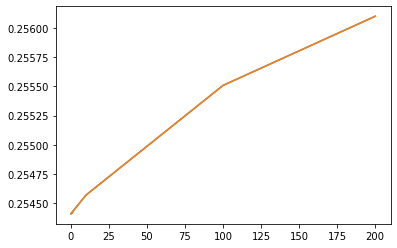

In [89]:
from sklearn.naive_bayes import MultinomialNB
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001,10,100,200)  
}
clf=MultinomialNB()

grid_search= GridSearchCV(clf, parameters,verbose=4,cv=3,return_train_score=True,refit=True)
grid_search.fit(final_train_matrix_without_scaling,y_train)
print("best parameter{}".format(grid_search.best_params_))


x=grid_search.cv_results_['mean_train_score']
y=grid_search.cv_results_['mean_test_score']
train_error=[1-i for i in x]
test_error=[1-i for i in x]
print(train_error,test_error)

print(x)
print(y)
plt.plot(parameters['alpha'],train_error,)
plt.plot(parameters['alpha'],test_error)
plt.show()
